In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from utils import DenseRagged, PermopRagged
from utils import sep_dist, measure_dist
from utils import sym_KL

from tensorflow.keras.regularizers import l1, l2

import mtd
import numpy as np
from scipy.stats import entropy

from tqdm import tqdm
import time

import matplotlib.pyplot as plt
from matplotlib import gridspec

from gudhi.representations import DiagramSelector
from sklearn.metrics import pairwise_distances
import seaborn as sns

import torch

import ot



# sns.set_theme(style="darkgrid")
FIG_SIZE = (18,5)
sns.set_context("talk")
plt.style.use('ggplot')

2024-11-06 16:44:50.657692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730900690.686583     437 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730900690.694952     437 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 16:44:50.722964: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Preparing data

In [2]:
N_sets_train = 900  # Number of train point clouds
N_sets_test  = 300  # Number of test  point clouds
N_points     = 600  # Point cloud cardinality
N_noise      = 200  # Number of corrupted points
n_boostrap = 1

In [3]:
from datasets.utils import create_multiple_circles

In [183]:
data_train,      label_train       = create_multiple_circles(N_sets_train, N_points, noisy=0, N_noise=N_noise)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 141.23it/s]


In [4]:
import gudhi as gd
from tqdm import tqdm

In [ ]:
# data_train = np.array(data_train)

# data_train.shape

# buffer = np.array([[i, j] for i in np.arange(900)[label_train==1] for j in np.arange(900)[label_train==2]])
# buffer_id =  np.random.choice(len(buffer), 1000, replace = False)
# train_indexes = buffer[buffer_id]

# buffer = np.array([[i, j] for i in np.arange(900)[label_train==1] for j in np.arange(900)[label_train==3]])
# buffer_id =  np.random.choice(len(buffer), 1000, replace = False)
# train_indexes = np.vstack((train_indexes, buffer[buffer_id]))

# buffer = np.array([[i, j] for i in np.arange(900)[label_train==2] for j in np.arange(900)[label_train==3]])
# buffer_id =  np.random.choice(len(buffer), 1000, replace = False)
# train_indexes = np.vstack((train_indexes, buffer[buffer_id]))

# # train_indexes = np.random.choice(900,(1000,2))

In [156]:
train_indexes

array([[858, 500],
       [390, 617],
       [304, 656],
       ...,
       [463,  68],
       [422, 404],
       [455, 346]])

([], [])

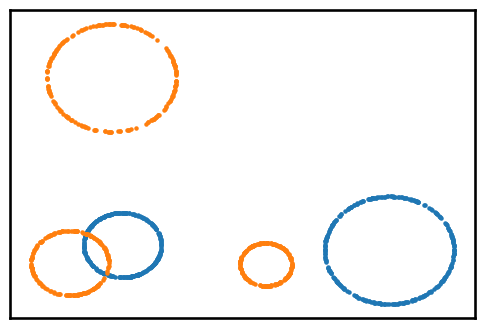

In [157]:
plt.scatter(data_train[600,:,0], data_train[600,:,1], s=3)
plt.scatter(data_train[728,:,0], data_train[728,:,1], s=3)
plt.xticks([])
plt.yticks([])

### Let's calculate density for choosen point clouds pairs with bootstrap.

In [158]:
# with open('RipsNet_exp/cross_pd_circles_3000_strat_boost_10_data.npy', 'wb') as f:
#     np.save(f, data_train)
# with open('RipsNet_exp/cross_pd_circles_3000_strat_boost_10_label.npy', 'wb') as f:
#     np.save(f, label_train)
# with open('RipsNet_exp/cross_pd_circles_3000_strat_boost_10_indexes.npy', 'wb') as f:
#     np.save(f, train_indexes)

In [159]:
n_boostrap = 10
train_PD = []
for i,j in tqdm(train_indexes):  
    barc = [mtd.calc_cross_barcodes(data_train[i], data_train[j], batch_size1 = 300, batch_size2 = 500, is_plot = False, pdist_device = "cuda") for _ in range(n_boostrap)]
    train_PD.append(barc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [3:13:20<00:00,  3.87s/it]


In [161]:
# import pickle
# with open("RipsNet_exp/cross_pd_circles_3000_strat_boost_10_PD.txt", "wb") as fp:   #Pickling
#     pickle.dump(train_PD, fp)

In [3]:
import pickle
with open('RipsNet_exp/cross_pd_circles_3000_strat_boost_10_data.npy', 'rb') as f:
    data_train = np.load(f)
with open('RipsNet_exp/cross_pd_circles_3000_strat_boost_10_label.npy', 'rb') as f:
    label_train = np.load(f)
with open('RipsNet_exp/cross_pd_circles_3000_strat_boost_10_indexes.npy', 'rb') as f:
    train_indexes = np.load(f)
with open("RipsNet_exp/cross_pd_circles_3000_strat_boost_10_PD.txt", 'rb') as fp:   #Pickling
    train_PD = pickle.load(fp)

In [4]:
n_boostrap = 10
# train_PD_1 = [x[1] if len(x[1])>0 else np.array([[0., 0.]]) for x in train_PD ]
train_PD_1 = [[x[1] if len(x[1])>0 else np.array([[0., 0.]]) for x in barcs ] for barcs in train_PD]

### Check how adequate these barcodes are

In [6]:
data_train.shape

(900, 600, 2)

In [7]:
inx_glob = np.random.choice(3000, 5, replace = False)
indexes = train_indexes[inx_glob]

In [ ]:
n_boostrap = 10
barcs_5 = []
for ids in tqdm(indexes):
    # print(ids)
    barc = [mtd.calc_cross_barcodes(data_train[ids[0]], data_train[ids[1]], batch_size1 = 300, batch_size2 = 500, is_plot = False, pdist_device = "cuda") for _ in range(n_boostrap)]
    barcs_5.append(barc)

  0%|                                                                                                                                                                                 | 0/5 [00:00<?, ?it/s]

In [30]:
barcs_5 = [[v[1] for v in smth] for smth in barcs_5]

In [31]:
pds_train = DiagramSelector(use=True).fit_transform(barcs_5[0])
vpdtr = np.vstack(pds_train)

for barcs in barcs_5[1:]:
    pds_train = DiagramSelector(use=True).fit_transform(barcs)
    vpdtr = np.vstack((vpdtr, np.vstack(pds_train)))

pers = vpdtr[:,1]-vpdtr[:,0]
# bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
# ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
# sigma = np.quantile(ppers, .2) ## доделать
im_bnds_2 = [np.quantile(vpdtr[:,0],0.001), np.quantile(vpdtr[:,0],0.9), np.quantile(pers,0.2), np.quantile(pers,0.999)]
im_bnds = [np.min(vpdtr[:,0]), np.quantile(vpdtr[:,0],0.9), np.min(pers), np.max(pers)]

In [32]:
im_bnds

[0.02967206, 2.844643759727478, 3.0338764e-05, 7.7922754]

In [33]:
im_bnds_2

[0.029672060161828995,
 2.844643759727478,
 0.002460062503814698,
 7.791886845588684]

In [34]:
from gudhi.representations import DiagramSelector
from sklearn.metrics import pairwise_distances
from gudhi.representations import  PersistenceImage

PI_5_all = []
for barcs in barcs_5:
    pds_train = DiagramSelector(use=True).fit_transform(barcs)
    
    
    vpdtr = np.vstack(pds_train)
    pers = vpdtr[:,1]-vpdtr[:,0]
    bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
    ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
    sigma = np.quantile(ppers, .2)
    
    
    PI_params = {'bandwidth': sigma, 'weight': lambda x: x[1], 
                 'resolution': [50,50], 'im_range': im_bnds}
    PI_5 = PersistenceImage(**PI_params).fit_transform(pds_train)
    PI_5 = np.sum(PI_5,axis = 0)/n_boostrap
    PI_5 = PI_5/np.sum(PI_5)
    PI_5_all.append(PI_5)
    
PI_5_all = np.array(PI_5_all)

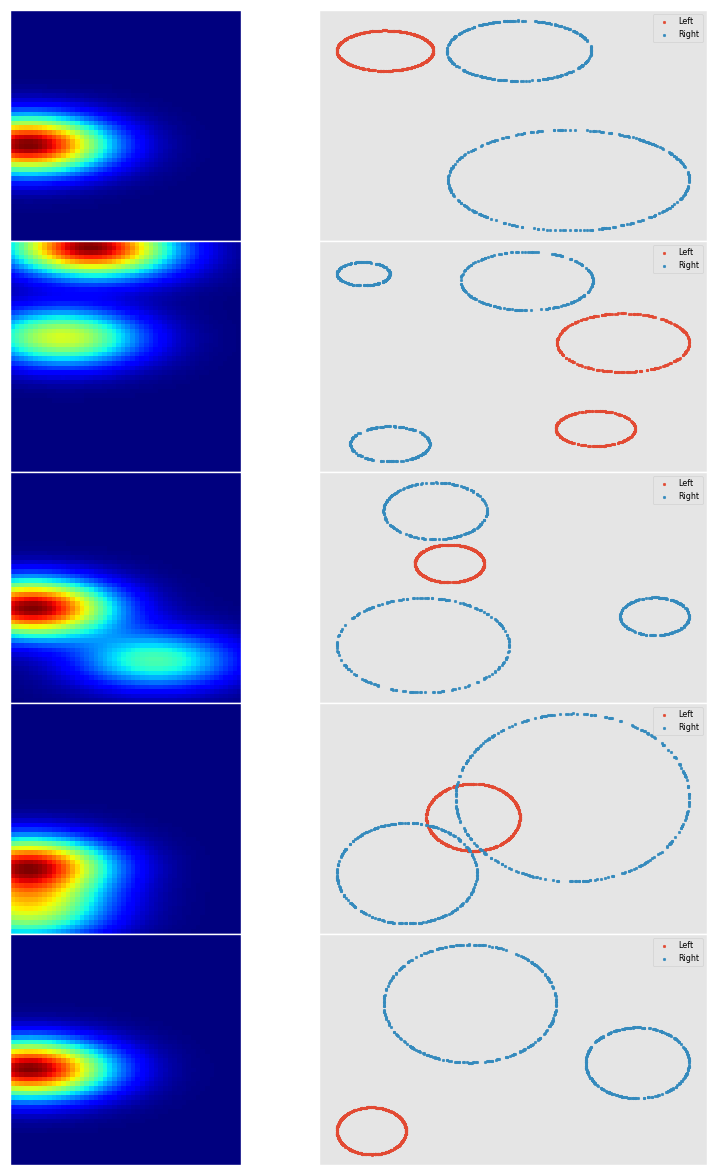

In [35]:
fig = plt.figure(figsize=(10, 15)) 
gs = gridspec.GridSpec(5, 2, width_ratios=[1,1], wspace=0.0, hspace=0.0)

for i in range(5):
    ax = plt.subplot(gs[i, 0])
    ax.imshow(np.flip(np.reshape(PI_5_all[i], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(gs[i, 1])
    ax.scatter(data_train[indexes[i][0],:, 0], data_train[indexes[i][0],:, 1], s=3,label = "Left")
    ax.scatter(data_train[indexes[i][1],:, 0], data_train[indexes[i][1],:, 1], s=3,label = "Right")
    plt.xticks([])
    plt.yticks([])
    plt.legend(fontsize = "xx-small")

---

### Calcullating all persistence images

##### Base transformation of y-axis to persistence is made automatically inside **gudhi.representations.PersistenceImage**

In [5]:
pds_train = DiagramSelector(use=True).fit_transform(train_PD_1[0])
vpdtr = np.vstack(pds_train)

for barcs in train_PD_1[1:]:
    pds_train = DiagramSelector(use=True).fit_transform(barcs)
    vpdtr = np.vstack((vpdtr, np.vstack(pds_train)))

pers = vpdtr[:,1]-vpdtr[:,0]
# bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
# ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
# sigma = np.quantile(ppers, .2) ## доделать
im_bnds = [np.min(vpdtr[:,0]), np.quantile(vpdtr[:,0],0.9), np.min(pers), np.max(pers)]

In [6]:
from gudhi.representations import DiagramSelector
from sklearn.metrics import pairwise_distances
from gudhi.representations import  PersistenceImage

PI_train_all = []
for barcs in tqdm(train_PD_1):
    pds_train = DiagramSelector(use=True).fit_transform(barcs)
    
    
    vpdtr = np.vstack(pds_train)
    pers = vpdtr[:,1]-vpdtr[:,0]
    bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])).flatten()
    ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
    sigma = np.quantile(ppers, .1)
    sigma = 0.1 if sigma < 1e-1 else sigma # we dont need sigma to be too small
    
    
    
    PI_params = {'bandwidth': sigma, 'weight': lambda x: x[1], 
                 'resolution': [50,50], 'im_range': im_bnds}
    PI_train = PersistenceImage(**PI_params).fit_transform(pds_train)
    PI_train = np.sum(PI_train,axis = 0)/n_boostrap
    PI_train = PI_train/np.sum(PI_train)
    PI_train_all.append(PI_train)
    
PI_train_all = np.array(PI_train_all)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:21<00:00, 140.45it/s]


In [7]:
PI_train = np.vstack([PI_train_all[:800], PI_train_all[1000:1800], PI_train_all[2000:2800]])
clean_PI_test = np.vstack([PI_train_all[800:1000], PI_train_all[1800:2000], PI_train_all[2800:3000]])

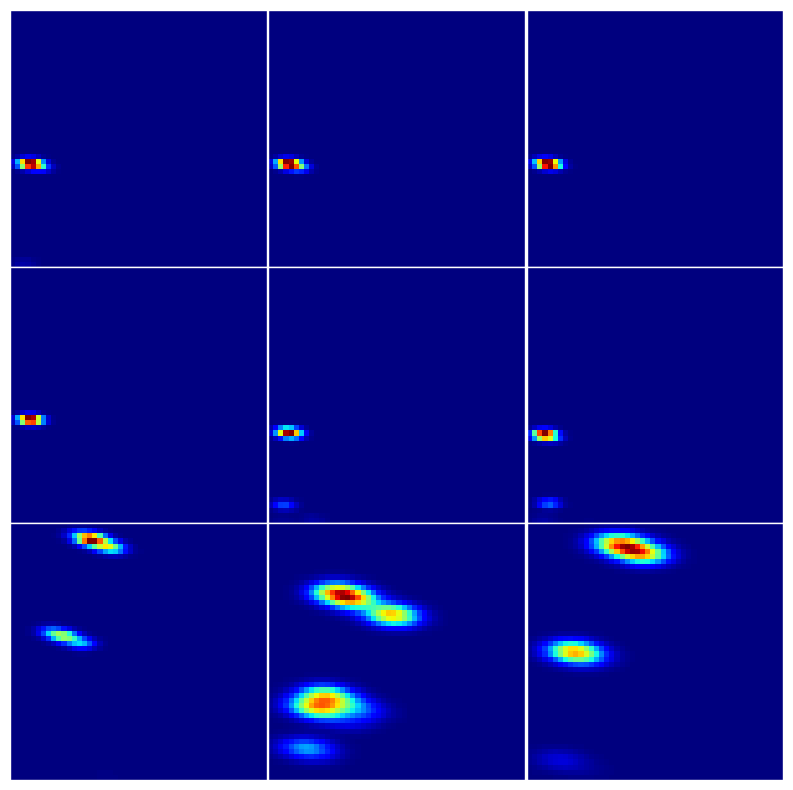

In [8]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(PI_train[1000*i+35*j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])

sigma: 0.1


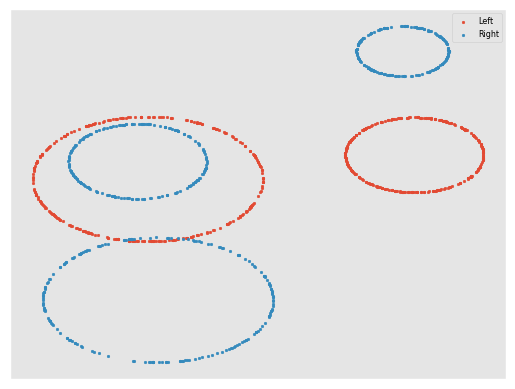

In [110]:
i  = 2000

ax = plt.subplot()
ax.scatter(data_train[train_indexes[i][0],:, 0], data_train[train_indexes[i][0],:, 1], s=3,label = "Left")
ax.scatter(data_train[train_indexes[i][1],:, 0], data_train[train_indexes[i][1],:, 1], s=3,label = "Right")
plt.xticks([])
plt.yticks([])
plt.legend(fontsize = "xx-small")
# train_PD_1[i]

pds_train = DiagramSelector(use=True).fit_transform(train_PD_1[i])
    

vpdtr = np.vstack(pds_train)
pers = vpdtr[:,1]-vpdtr[:,0]
bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])).flatten()
ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
sigma = np.quantile(ppers, .1)
sigma = 0.1 if sigma < 1e-1 else sigma



PI_params = {'bandwidth': sigma, 'weight': lambda x: x[1], 
                 'resolution': [50,50], 'im_range': im_bnds}
PI_train = PersistenceImage(**PI_params).fit_transform(pds_train)
PI_train = np.sum(PI_train,axis = 0)/n_boostrap
PI_train = PI_train/np.sum(PI_train)
print(f"sigma: {sigma}")
# plt.imshow(np.flip(np.reshape(PI_train, [50,50]), 0), cmap='jet')

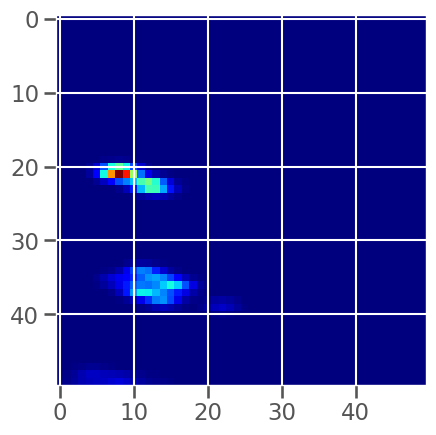

In [111]:
plt.imshow(np.flip(np.reshape(PI_train, [50,50]), 0), cmap='jet')

### First approach: just consider two point clouds as one big and preprocess them simultaneously

In [9]:
data_train_concat = np.array([np.vstack((data_train[i],data_train[j])) for i,j in np.vstack([train_indexes[:800], train_indexes[1000:1800], train_indexes[2000:2800]])])
data_test_concat = np.array([np.vstack((data_train[i],data_train[j])) for i,j in np.vstack([train_indexes[800:1000], train_indexes[1800:2000], train_indexes[2800:3000]])])

In [ ]:
tf_data_train = tf.ragged.constant([
    [list(c) for c in list(data_train_concat[i])] for i in range(len(data_train_concat))], ragged_rank=1)
tf_data_test = tf.ragged.constant([
    [list(c) for c in list(data_test_concat[i])] for i in range(len(data_test_concat))], ragged_rank=1)

```python
find / -name 'libcudart.so.11.0'

# edit /etc/profile
sudo vim /etc/profile
# append path to "LD_LIBRARY_PATH" in profile file
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:usr/local/cuda-11.7/targets/x86_64-linux/lib/libcudart.so.11.0
# make environment file work
source /etc/profile
```

### Model

In [ ]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-8, 
#                                             patience=400, verbose=0, mode='auto', baseline=None, 
#                                             restore_best_weights=True)

# optim = tf.keras.optimizers.Adamax(learning_rate=5e-4)
# inputs = tf.keras.Input(shape=(None,2), dtype ="float32", ragged=True)

# x = DenseRagged(units=40, use_bias=True, activation='relu')(inputs)
# x = DenseRagged(units=30, use_bias=True, activation='relu')(x)
# x = DenseRagged(units=15, use_bias=True, activation='relu')(x)
# x = PermopRagged()(x)
# # x = tf.keras.layers.Normalization()(x)
# x = tf.keras.layers.Dense(50,  activation='relu')(x)
# x = tf.keras.layers.Dropout(0.3)(x)
# x = tf.keras.layers.Dense(100, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.3)(x)
# x = tf.keras.layers.Dense(200, activation='relu')(x)

# outputs = tf.keras.layers.Dense(PI_train.shape[1], activation='sigmoid')(x)
# outputs = tf.keras.layers.Lambda(lambda x: tf.experimental.numpy.clip(x, 1e-8, None))(outputs) ## for preventiong calculating log(0)
# outputs = tf.keras.layers.Lambda(lambda x: x / (tf.reduce_sum(x, axis=-1, keepdims=True) + 1e-7))(outputs)

# model_PI = tf.keras.Model(inputs=inputs, outputs=outputs)
# model_PI.compile(optimizer=optim, loss="mse")


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, 
                                            patience=200, verbose=0, mode='auto', baseline=None, 
                                            restore_best_weights=False)
optim = tf.keras.optimizers.Adamax(learning_rate=5e-4)
inputs = tf.keras.Input(shape=(None,2), dtype ="float32", ragged=True)

x = DenseRagged(units=30, use_bias=True, activation='relu')(inputs)
x = DenseRagged(units=20, use_bias=True, activation='relu')(x)
x = DenseRagged(units=10, use_bias=True, activation='relu')(x)
x = PermopRagged()(x)
x = tf.keras.layers.Dense(50,  activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dense(200, activation='relu')(x)
outputs = tf.keras.layers.Dense(PI_train.shape[1], activation='sigmoid')(x)
model_PI = tf.keras.Model(inputs=inputs, outputs=outputs)
model_PI.compile(optimizer=optim, loss="mse")

There we can try KL loss for better understanding

In [ ]:
start_time = time.time()

history = model_PI.fit(tf_data_train, PI_train, epochs=2000, 
                       validation_data=(tf_data_test, clean_PI_test), callbacks=[callback], verbose=0)

plt.plot(np.array(history.history["loss"][20:]))
plt.plot(np.array(history.history["val_loss"][20:]))
plt.legend(["loss", "val_loss"])
plt.show()

train_PI_prediction = model_PI.predict(tf_data_train)
clean_PI_prediction = model_PI.predict(tf_data_test)

print("Model fitted for --- %s seconds ---" % (time.time() - start_time))

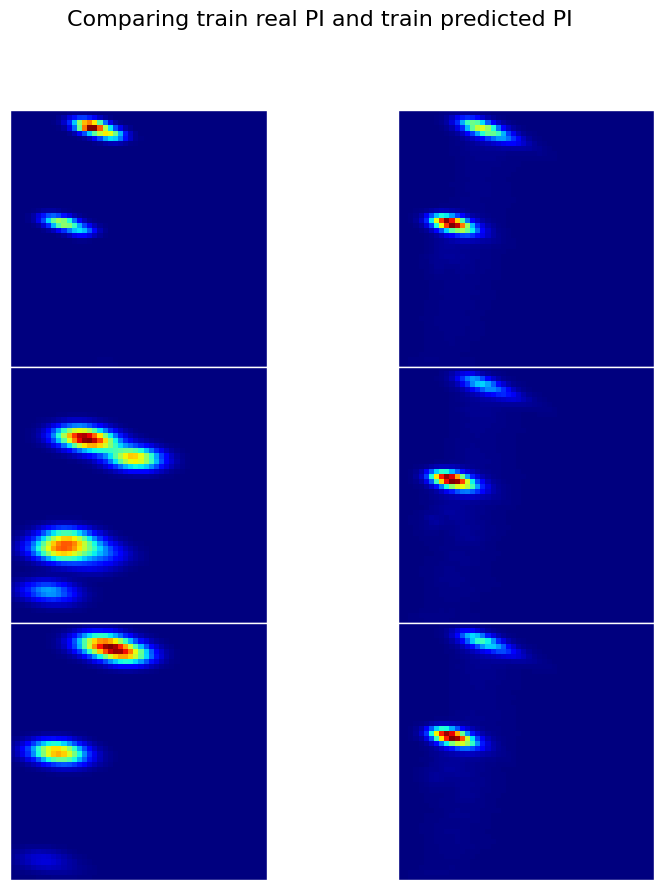

In [157]:
fig = plt.figure(figsize=(10, 10)) 
fig.suptitle(f"Comparing train real PI and train predicted PI", fontsize=16)
gs = gridspec.GridSpec(3, 2, width_ratios=[1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    ax = plt.subplot(gs[i,0])
    ax.imshow(np.flip(np.reshape(PI_train[1000*2+35*i], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])
    ax = plt.subplot(gs[i,1])
    ax.imshow(np.flip(np.reshape(train_PI_prediction[1000*2+35*i], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])

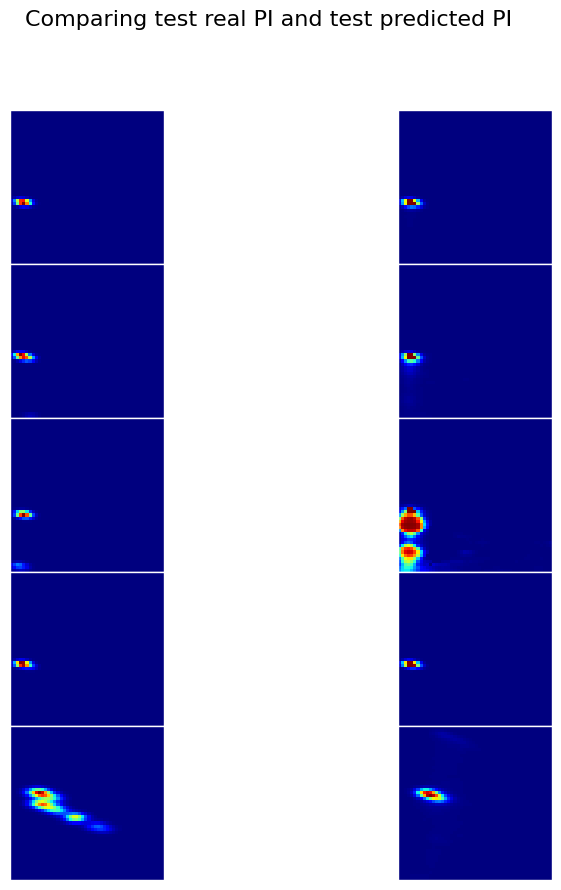

In [158]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle(f"Comparing test real PI and test predicted PI", fontsize=16)
gs = gridspec.GridSpec(5, 2, width_ratios=[1,1], wspace=0.0, hspace=0.0)
for i in range(5):
    ax = plt.subplot(gs[i,0])
    ax.imshow(np.flip(np.reshape(clean_PI_test[100*i+2*i], [50,50]), 0), cmap='jet',)
    plt.xticks([])
    plt.yticks([])

    ax = plt.subplot(gs[i,1])
    # ax.set_title(f"{labels[train_indexes[100*i][0]]} vs {labels[train_indexes[100*i][1]]}")
    ax.imshow(np.flip(np.reshape(clean_PI_prediction[100*i+2*i], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])

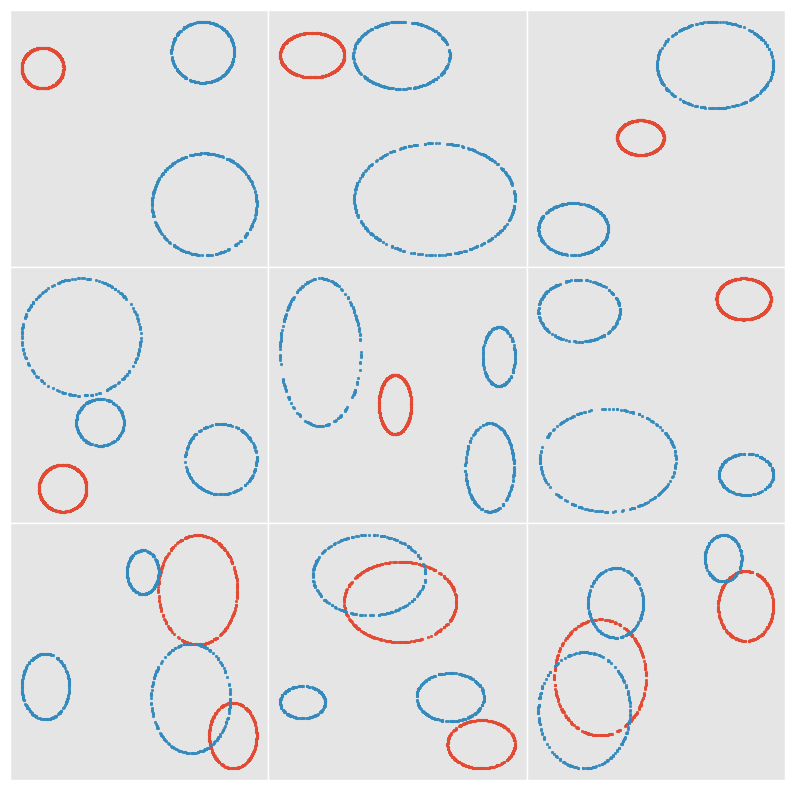

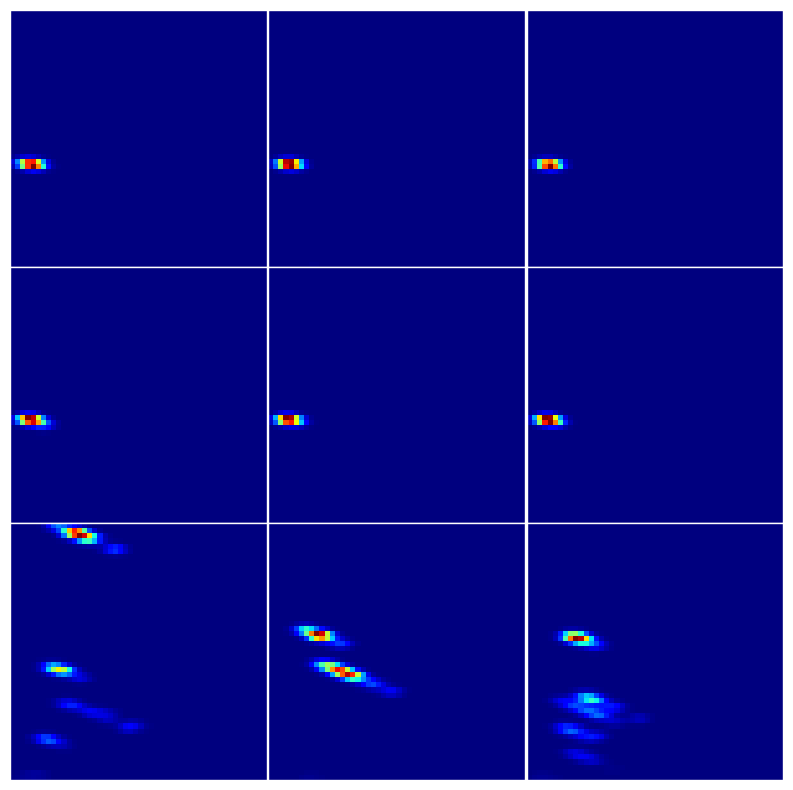

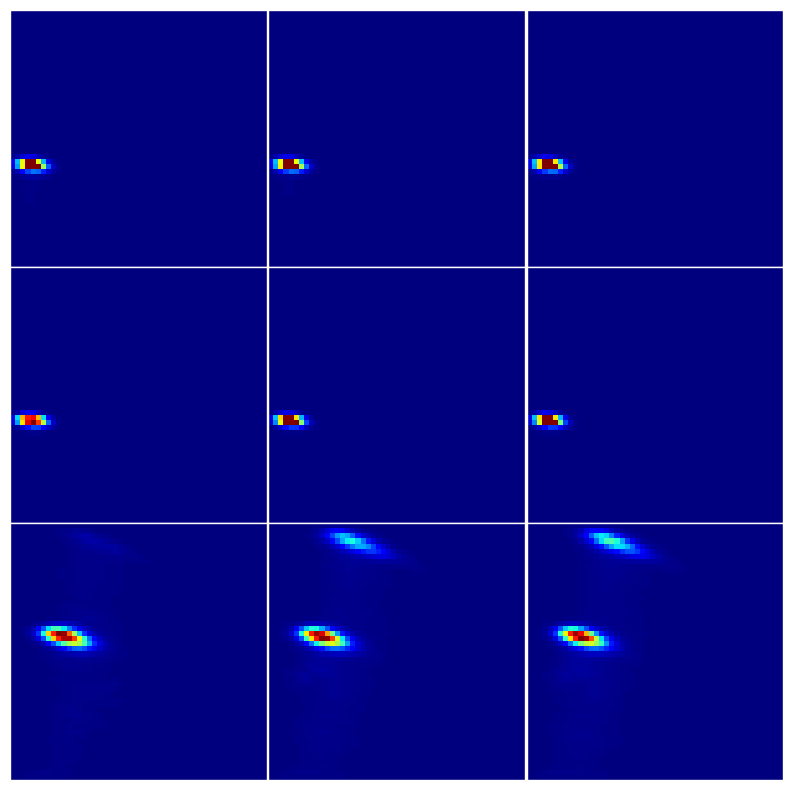

In [159]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(tf_data_test[200*i+j,:N_points,0], tf_data_test[200*i+j,:N_points,1], s=3)
        ax.scatter(tf_data_test[200*i+j,N_points:,0], tf_data_test[200*i+j,N_points:,1], s=3)
        plt.xticks([])
        plt.yticks([])
# plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(clean_PI_test[200*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])
# plt.savefig('clean_gudhi_pi.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(clean_PI_prediction[200*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])
# plt.savefig('clean_ripsnet_pi.png', bbox_inches='tight')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 869.92it/s]


Mean KL distance: 4.107572865972328


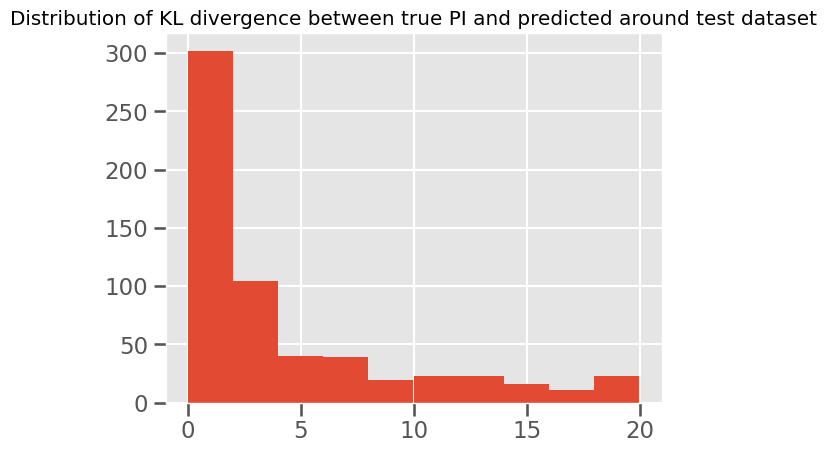

In [160]:
distances = measure_dist(clean_PI_prediction, clean_PI_test, method = "sym_KL")
plt.hist(distances)
plt.title("Distribution of sym KL divergence between true PI and predicted around test dataset")
plt.show()

### Second approach: consider point clouds individually and as one big simultaneously. It means that we want to process clouds independently and together and, in the end, concatenate the results and pass them further to the NN.

In [131]:
# from scipy.stats import entropy

# from utils import sym_KL

# def sym_KL(y_true, y_pred):
#     loss = tf.keras.losses.KLDivergence()
#     return (loss(y_true, y_pred) + loss(y_pred, y_true))/2


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-8, 
                                            patience=100, verbose=0, mode='auto', baseline=None, 
                                            restore_best_weights=True)

dropout_rate = 0.2
optim = tf.keras.optimizers.Adamax(learning_rate=1e-4)
inputs_1 = tf.keras.Input(shape=(None,2), dtype ="float32", ragged=True)
inputs_2 = tf.keras.Input(shape=(None,2), dtype ="float32", ragged=True)
inputs_dist = tf.keras.Input(shape=(N_points, 30), dtype ="float32", ragged=False)

x = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_1)
x = DenseRagged(units=20, use_bias=True, activation='relu')(x)
x = DenseRagged(units=10, use_bias=True, activation='relu')(x)
x = PermopRagged()(x)

y = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_2)
y = DenseRagged(units=20, use_bias=True, activation='relu')(y)
y = DenseRagged(units=10, use_bias=True, activation='relu')(y)
y = PermopRagged()(y)

x_y = keras.layers.Concatenate(axis=1)([inputs_1, inputs_2])
x_y = DenseRagged(units=30, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=20, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=10, use_bias=True, activation='relu')(x_y)
x_y= PermopRagged()(x_y)

d = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_dist)
d = DenseRagged(units=20, use_bias=True, activation='relu')(d)
d = DenseRagged(units=10, use_bias=True, activation='relu')(d)
d = PermopRagged()(d)


z = keras.layers.Concatenate(axis=-1)([x, y, x_y, d])

# z = keras.layers.Concatenate(axis=-1)([x, y, x_y])
z = tf.keras.layers.Normalization()(z)
z = tf.keras.layers.Dense(150,  activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(dropout_rate)(z)
z = tf.keras.layers.Dense(200, activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(dropout_rate)(z)
z = tf.keras.layers.Dense(400, activation='relu', kernel_regularizer=l2(1e-3), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(dropout_rate)(z)
outputs = tf.keras.layers.Dense(PI_train.shape[1], activation='sigmoid')(z)
outputs = tf.keras.layers.Lambda(lambda x: tf.experimental.numpy.clip(x, 1e-8, None))(outputs) ## for preventiong calculating log(0)
outputs = tf.keras.layers.Lambda(lambda x: x / (tf.reduce_sum(x, axis=-1, keepdims=True) + 1e-7))(outputs)
model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2, inputs_dist], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss=sym_KL)

In [18]:
tf_data_train_1 = tf.ragged.constant([
    [list(c) for c in list(data_train_concat[i, :N_points])] for i in range(len(data_train_concat))], ragged_rank=1)
tf_data_train_2 = tf.ragged.constant([
    [list(c) for c in list(data_train_concat[i, N_points:])] for i in range(len(data_train_concat))], ragged_rank=1)


tf_data_test_1 = tf.ragged.constant([
    [list(c) for c in list(data_test_concat[i, :N_points])] for i in range(len(data_test_concat))], ragged_rank=1)
tf_data_test_2 = tf.ragged.constant([
    [list(c) for c in list(data_test_concat[i, N_points:])] for i in range(len(data_test_concat))], ragged_rank=1)

W0000 00:00:1730897814.226700    7397 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Let's calculate pairwise distances as new features 

In [ ]:
start_time = time.time()
pdist_train = np.zeros((data_train_concat.shape[0], N_points, 2*N_points))
for i in tqdm(range(data_train_concat.shape[0]), desc = "pdist for train dataset"):
    cloud_1 = data_train_concat[i, :N_points]
    cloud_2 = data_train_concat[i, N_points:]
    # NB !
    # Swapping point clouds for consistency with the paper
    cloud_1, cloud_2 = cloud_2, cloud_1
    
    d = sep_dist(cloud_1, cloud_2, pdist_device = "cuda")
    m = d[cloud_1.shape[0]:, :cloud_1.shape[0]].mean()
    d[:cloud_1.shape[0]][:cloud_1.shape[0]] = 0
    d[d < m*(1e-6)] = 0
    # pdist_train.append(d)
    pdist_train[i, :, :] = d[N_points:, :] ## because all upper numbers equal to zero

pdist_test = np.zeros((data_test_concat.shape[0], N_points, 2*N_points))
for i in tqdm(range(data_test_concat.shape[0]), desc = "pdist for test dataset"):
    cloud_1 = data_test_concat[i, :N_points]
    cloud_2 = data_test_concat[i, N_points:]
    # NB !
    # Swapping point clouds for consistency with the paper
    cloud_1, cloud_2 = cloud_2, cloud_1
    
    d = sep_dist(cloud_1, cloud_2, pdist_device = "cuda")
    m = d[cloud_1.shape[0]:, :cloud_1.shape[0]].mean()
    d[:cloud_1.shape[0]][:cloud_1.shape[0]] = 0
    d[d < m*(1e-6)] = 0
    pdist_test[i, :, :] = d[N_points:, :] ## because all upper numbers equal to zero
    
print("Distance maatrix calculationn took --- %s seconds ---" % (time.time() - start_time))

### There I am gonna try different aproaches of information extraction:

In [ ]:
from sklearn.decomposition import PCA

n_features = 30

In [164]:
start_time = time.time()

pca = PCA(n_components=n_features)
pdist_train_reducted_pca = np.array([pca.fit_transform(cloud) for cloud in pdist_train])
pdist_test_reducted_pca = np.array([pca.fit_transform(cloud) for cloud in pdist_test])

print("Distance matrix reducted by PCA for --- %s seconds ---" % (time.time() - start_time))

In [ ]:
start_time = time.time()

pdist_train_reducted_max = pdist_train[np.argsort(pdist_train, axis = 1)[:n_features]]
pdist_test_reducted_max = pdist_test[np.argsort(pdist_test, axis = 1)[:n_features]]

print("Distance matrix reducted by MAX for --- %s seconds ---" % (time.time() - start_time))

In [ ]:
start_time = time.time()

percentiles = np.linspace(0, 100, 30)

pdist_train_reducted_quant = np.percentile(pdist_train, percentiles, axis=1, method = "closest_observation")
pdist_test_reducted_quant = pdist_test[np.argsort(pdist_test, percentiles, axis = 1,  method = "closest_observation")

print("Distance matrix reducted by Quantile for --- %s seconds ---" % (time.time() - start_time))

---
### Не совсем верный подход, нужно подумать как не обучать пса каждый раз
---

### Training different models

In [ ]:
start_time = time.time()

model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2, inputs_dist], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss=sym_KL)

history_pca = model_PI_second_type.fit([tf_data_train_1, tf_data_train_2, pdist_train_reducted_pca], PI_train, epochs=3000, 
                       validation_data=([tf_data_test_1, tf_data_test_2, pdist_test_reducted_pca], clean_PI_test), callbacks=[callback], verbose=0)


train_PI_prediction_second_type_pca = model_PI_second_type.predict([tf_data_train_1, tf_data_train_2, pdist_train_reducted_pca])
clean_PI_prediction_second_type_pca = model_PI_second_type.predict([tf_data_test_1, tf_data_test_2, pdist_test_reducted_pca])

plt.plot(np.array(history_pca.history["loss"][20:]))
plt.plot(np.array(history_pca.history["val_loss"][20:]))
plt.legend(["loss", "val_loss"])
plt.title("Second type model with PCA_dist")
plt.show()

print("Model fitted for --- %s seconds ---" % (time.time() - start_time))

In [ ]:
start_time = time.time()

model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2, inputs_dist], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss=sym_KL)

history_max = model_PI_second_type.fit([tf_data_train_1, tf_data_train_2, pdist_train_reducted_max], PI_train, epochs=3000, 
                       validation_data=([tf_data_test_1, tf_data_test_2, pdist_test_reducted_max], clean_PI_test), callbacks=[callback], verbose=0)

train_PI_prediction_second_type_max = model_PI_second_type.predict([tf_data_train_1, tf_data_train_2, pdist_train_reducted_max])
clean_PI_prediction_second_type_max= model_PI_second_type.predict([tf_data_test_1, tf_data_test_2, pdist_test_reducted_max])

plt.plot(np.array(history_max.history["loss"][20:]))
plt.plot(np.array(history_max.history["val_loss"][20:]))
plt.legend(["loss", "val_loss"])
plt.title("Second type model with MAX_dist")
plt.show()

print("Model fitted for --- %s seconds ---" % (time.time() - start_time))

In [ ]:
start_time = time.time()

model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2, inputs_dist], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss=sym_KL)

history_quant = model_PI_second_type.fit([tf_data_train_1, tf_data_train_2, pdist_train_reducted_quant], PI_train, epochs=3000, 
                       validation_data=([tf_data_test_1, tf_data_test_2, pdist_test_reducted_quant], clean_PI_test), callbacks=[callback], verbose=0)

train_PI_prediction_second_type_quant = model_PI_second_type.predict([tf_data_train_1, tf_data_train_2, pdist_train_reducted_quant])
clean_PI_prediction_second_type_quant = model_PI_second_type.predict([tf_data_test_1, tf_data_test_2, pdist_test_reducted_quant])


plt.plot(np.array(history_quant.history["loss"][20:]))
plt.plot(np.array(history_quant.history["val_loss"][20:]))
plt.legend(["loss", "val_loss"])
plt.title("Second type model with QUANT_dist")
plt.show()

print("Model fitted for --- %s seconds ---" % (time.time() - start_time))

---
### Comarinng results 

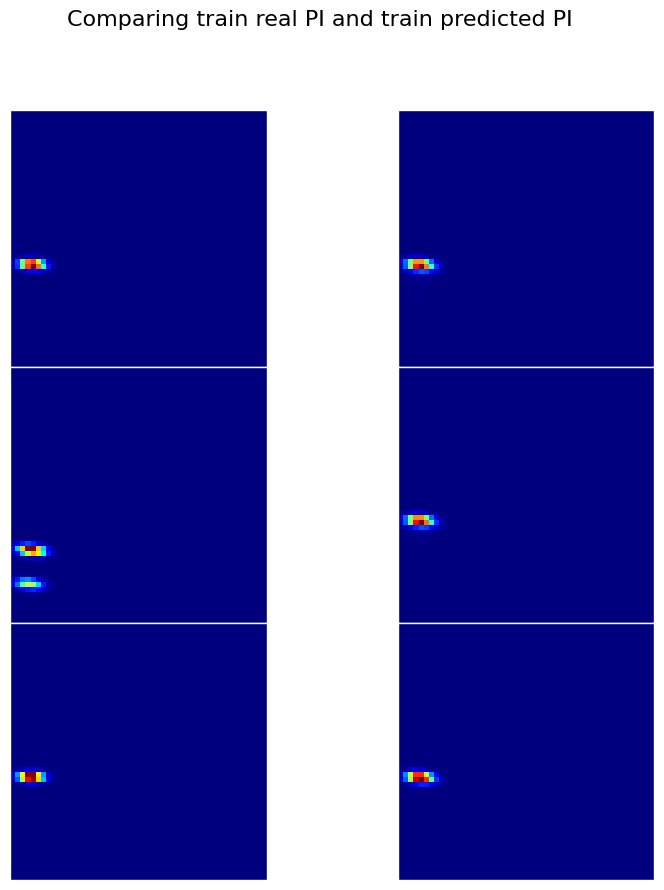

In [185]:
fig = plt.figure(figsize=(10, 10)) 
fig.suptitle(f"Comparing train real PI and train predicted PI", fontsize=16)
gs = gridspec.GridSpec(3, 4, width_ratios=[1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    ax = plt.subplot(gs[i,0])
    ax.imshow(np.flip(np.reshape(PI_train[200*i+60], [50,50]), 0), cmap='jet')
    if i == 0:
        plt.title("Real PI")
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(gs[i,1])
    ax.imshow(np.flip(np.reshape(train_PI_prediction_second_type_pca[200*i+1], [50,50]), 0), cmap='jet')
    if i == 0:
        plt.title("Predicted PI_pca")
    plt.xticks([])
    plt.yticks([])

    ax = plt.subplot(gs[i,2])
    ax.imshow(np.flip(np.reshape(train_PI_prediction_second_type_max[200*i+1], [50,50]), 0), cmap='jet')
    if i == 0:
        plt.title("Predicted PI_max")
    plt.xticks([])
    plt.yticks([])

    ax = plt.subplot(gs[i,3])
    ax.imshow(np.flip(np.reshape(train_PI_prediction_second_type_quant[200*i+1], [50,50]), 0), cmap='jet')
    if i == 0:
        plt.title("Predicted PI_quantile")
    plt.xticks([])
    plt.yticks([])

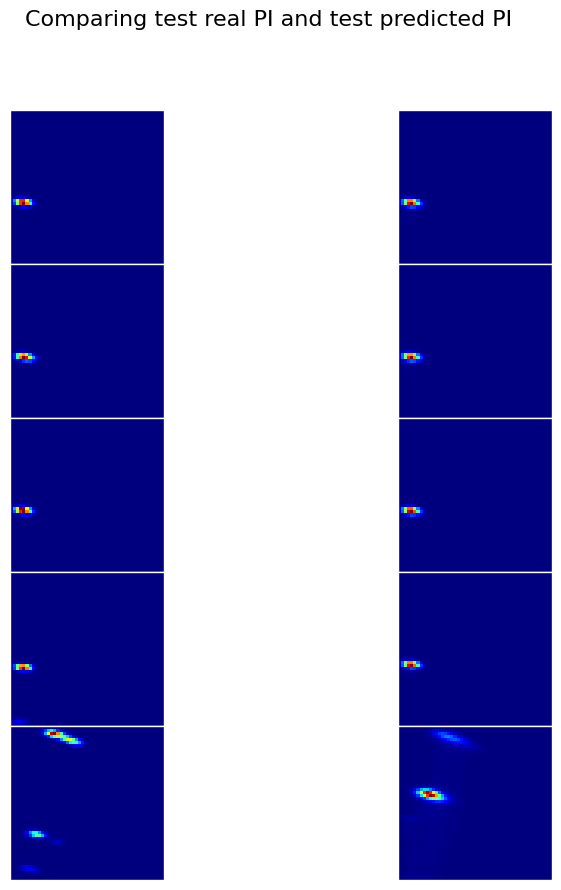

In [186]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle(f"Comparing test real PI and test predicted PI", fontsize=16)
gs = gridspec.GridSpec(5, 2, width_ratios=[1,1], wspace=0.0, hspace=0.0)
for i in range(5):
    ax = plt.subplot(gs[i,0])
    ax.imshow(np.flip(np.reshape(clean_PI_test[100*i+i], [50,50]), 0), cmap='jet',)
    plt.xticks([])
    plt.yticks([])

    ax = plt.subplot(gs[i,1])
    # ax.set_title(f"{labels[train_indexes[100*i][0]]} vs {labels[train_indexes[100*i][1]]}")
    ax.imshow(np.flip(np.reshape(clean_PI_prediction_second_type[100*i+i], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])

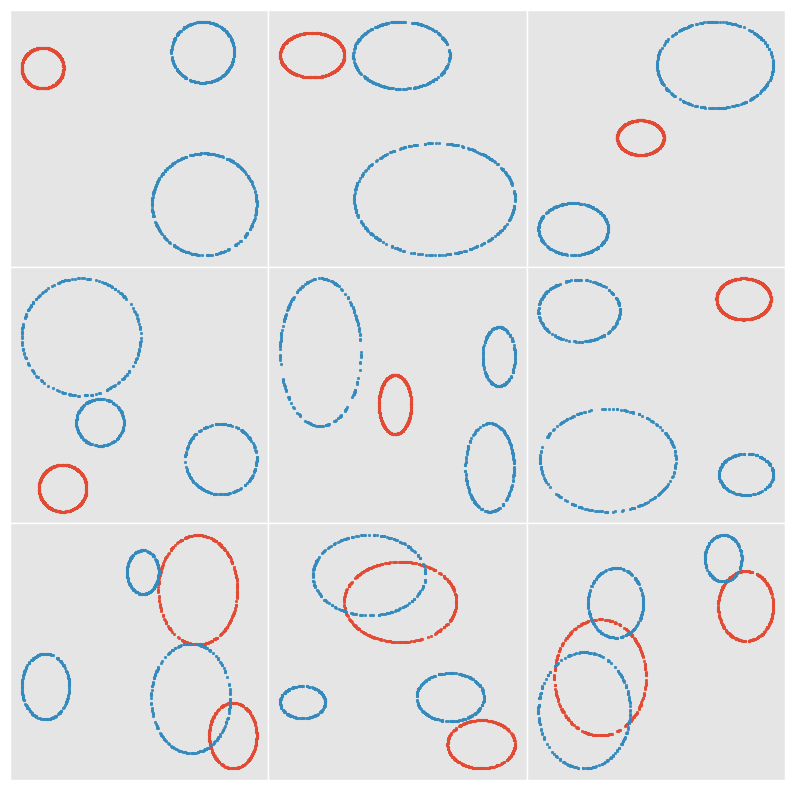

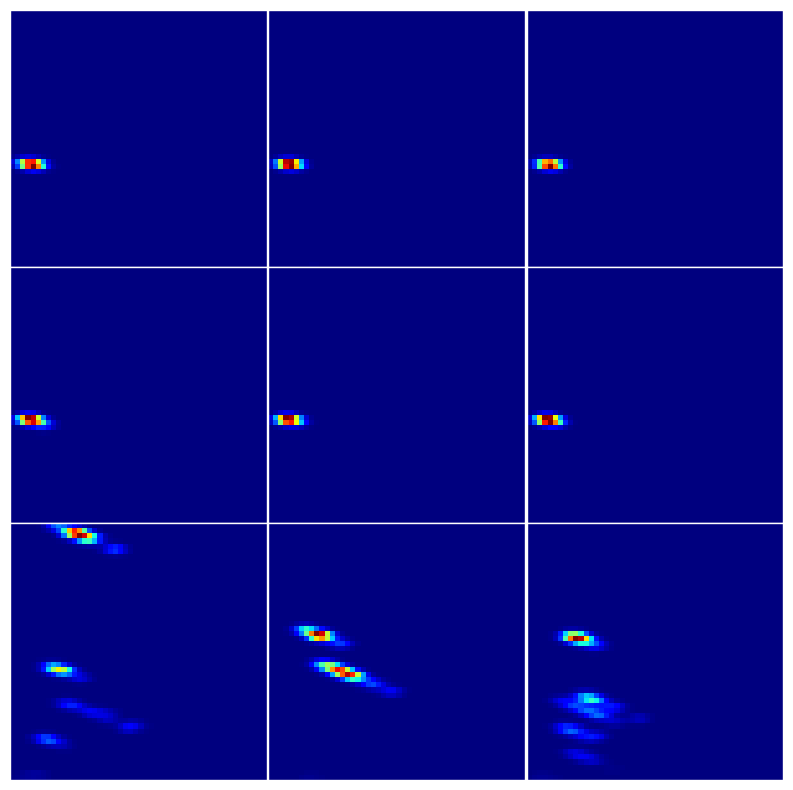

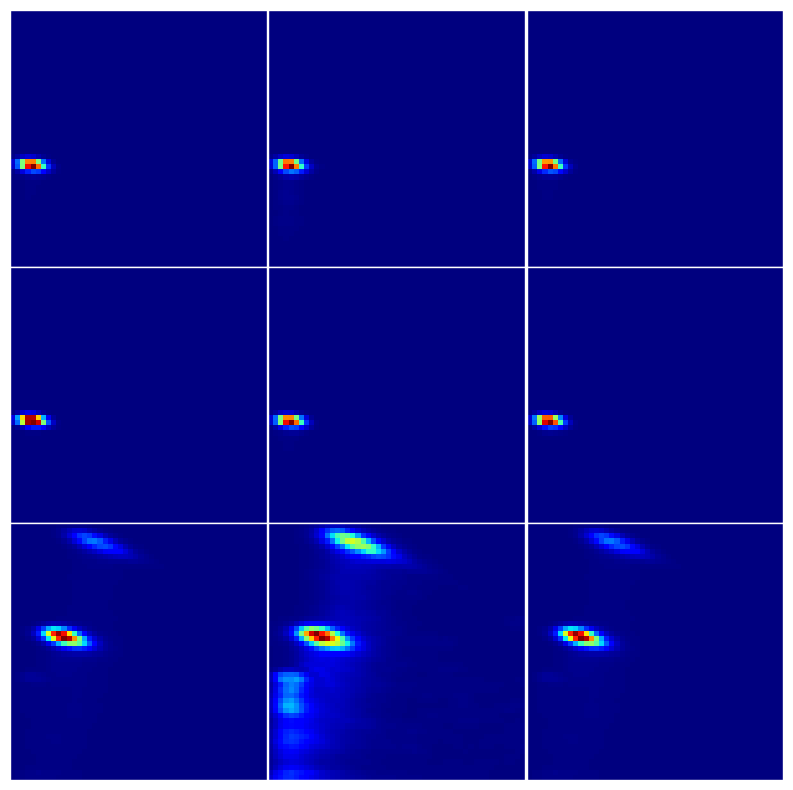

In [187]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(tf_data_test[200*i+j,:N_points,0], tf_data_test[200*i+j,:N_points,1], s=3)
        ax.scatter(tf_data_test[200*i+j,N_points:,0], tf_data_test[200*i+j,N_points:,1], s=3)
        plt.xticks([])
        plt.yticks([])
# plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(clean_PI_test[200*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])
# plt.savefig('clean_gudhi_pi.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(clean_PI_prediction_second_type_pca[200*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])
# plt.savefig('clean_ripsnet_pi.png', bbox_inches='tight')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 1044.84it/s]


Mean KL distance: 4.483214738250863


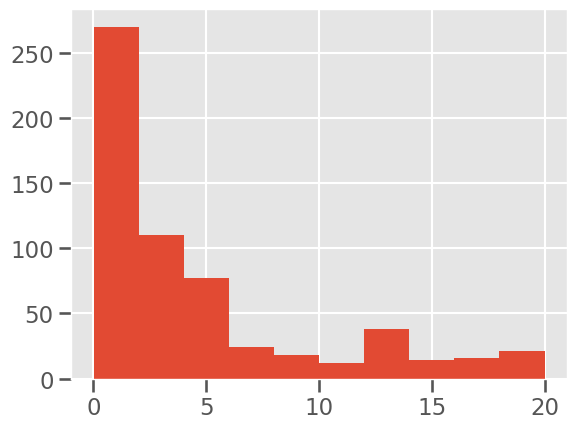

In [188]:
distances = measure_dist(clean_PI_prediction_second_type_pca, clean_PI_test, method="sym_KL")
plt.hist(distances)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 316.19it/s]


Mean KL distance: 3.9817281601509453
Loss computed by model V2: 3.809678316116333
Loss computed by model V2 reverse: 3.809678554534912
Loss computed by model V1: 2.461350917816162


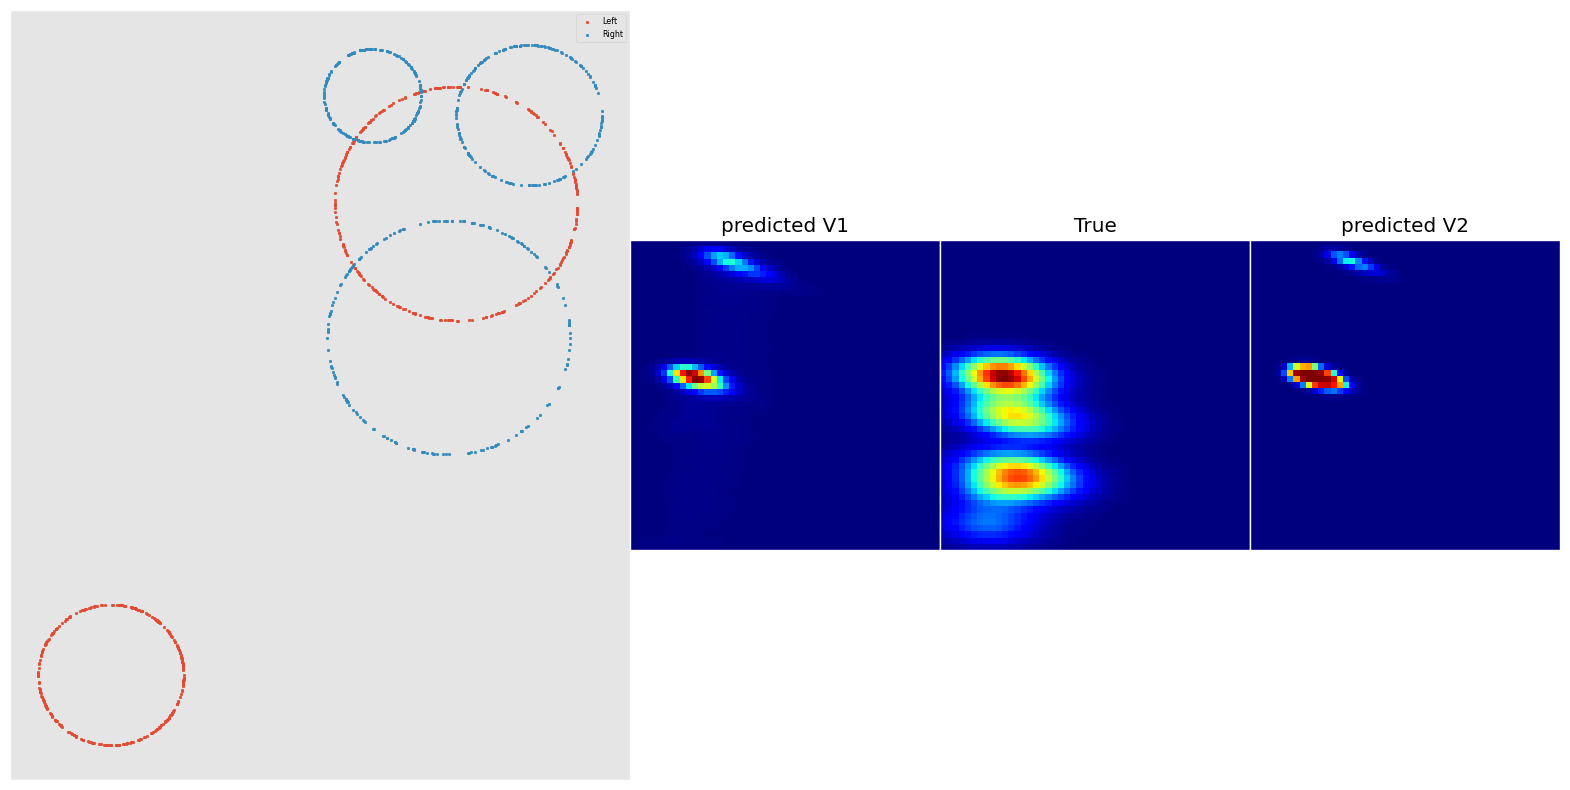

In [189]:
i_1 = 500
fig = plt.figure(figsize=(20, 10)) 
gs = gridspec.GridSpec(1, 4, width_ratios=[2,1,1,1], wspace=0.0, hspace=0.0)


ax = plt.subplot(gs[0])
ax.scatter(tf_data_test[i_1,:N_points,0], tf_data_test[i_1,:N_points,1], s=3,label = "Left")
ax.scatter(tf_data_test[i_1,N_points:,0], tf_data_test[i_1,N_points:,1], s=3,label = "Right")
plt.xticks([])
plt.yticks([])
plt.legend(fontsize = "xx-small")

ax = plt.subplot(gs[1])
ax.imshow(np.flip(np.reshape(clean_PI_prediction[i_1], [50,50]), 0), cmap='jet')
plt.xticks([])
plt.yticks([])
plt.title("predicted V1")

ax = plt.subplot(gs[2])
ax.imshow(np.flip(np.reshape(clean_PI_test[i_1], [50,50]), 0), cmap='jet')
plt.xticks([])
plt.yticks([])
plt.title("True")

ax = plt.subplot(gs[3])
ax.imshow(np.flip(np.reshape(clean_PI_prediction_second_type[i_1], [50,50]), 0), cmap='jet')
plt.xticks([])
plt.yticks([])
plt.title("predicted V2")

P = tf.convert_to_tensor([np.flip(np.reshape(clean_PI_test[i_1], [50,50]), 0).flatten()])
Q = tf.convert_to_tensor([np.flip(np.reshape(clean_PI_prediction_second_type[i_1], [50,50]), 0).flatten()])
R = tf.convert_to_tensor([np.flip(np.reshape(clean_PI_prediction[i_1], [50,50]), 0).flatten()])

measure_dist(Q, P, method="sym_KL")

print(f"Loss computed by model V2: {model_PI_second_type.compiled_loss([P],[Q])}")
print(f"Loss computed by model V2 reverse: {model_PI_second_type.compiled_loss([Q],[P])}")
print(f"Loss computed by model V1: {model_PI_second_type.compiled_loss([P],[R])}")